In [1]:
# 构建RAG应用：第一部分
# 本教程旨在指导您构建一个基于文本数据源的简单问答（Q&A）应用程序。我们将深入探讨典型的Q&A架构，并重点介绍RAG技术。

# 什么是RAG？
# RAG（Retrieval Augmented Generation）是一种结合了信息检索和文本生成的技术，用于增强大型语言模型（LLM）的问答能力。它通过在生成答案之前从外部知识库中检索相关信息，从而使LLM能够提供更准确、更具体、更少幻觉的回答。

# 典型的RAG应用程序包含两个主要组件：

# 索引（Indexing）: 这是一个用于从数据源摄取数据并对其进行索引的管道。这个过程通常是离线进行的。

# 检索和生成（Retrieval and Generation）: 这是实际的RAG链，它在运行时接收用户查询，从索引中检索相关数据，然后将这些数据传递给语言模型以生成答案。

# 从原始数据到答案的完整序列通常包括以下步骤：

# 索引阶段：

# 加载（Load）: 使用Document Loaders加载数据。

# 分割（Split）: 使用Text Splitters将大型文档分割成更小的块，以便于搜索和适应模型的上下文窗口。

# 存储（Store）: 将分割后的文本块存储并索引起来，通常使用VectorStore和Embeddings模型。

# 检索和生成阶段：

# 检索（Retrieve）: 根据用户输入，使用Retriever从存储中检索相关的文本块。

# 生成（Generate）: ChatModel / LLM结合检索到的数据和原始问题，通过一个提示（Prompt）来生成答案。

# 我们将使用LangGraph作为编排框架来实现检索和生成步骤。

# 环境设置 (Setup)
# 在开始之前，我们需要安装一些必要的库并配置LangSmith（可选，但强烈推荐用于跟踪应用）。

# Jupyter Notebook: 建议在Jupyter Notebook环境中运行本教程，以获得更好的交互体验。如果您尚未安装，请参考Jupyter官方文档进行安装。

# 安装依赖:
# 打开您的PowerShell命令行，然后执行以下pip安装命令。

# pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph
# pip install -qU "langchain[google-genai]"
# pip install -qU langchain-google-genai
# pip install -qU langchain-chroma
# 请注意：

# --quiet 或 -q 参数是为了在安装过程中减少输出信息。

# -U 参数是为了确保安装的库是最新版本。


In [2]:
# LangSmith 配置 (可选但推荐):
# LangSmith 是 LangChain 应用程序的调试、测试、评估和监控平台。它能帮助我们追踪复杂应用中的LLM调用。

# 首先，您需要注册 LangSmith 并获取 LANGSMITH_API_KEY。
# 然后，在您的PowerShell环境中设置环境变量：
# 请将 `YOUR_LANGSMITH_API_KEY` 替换为您自己的LangSmith API Key。

# $env:LANGSMITH_TRACING="true"
# $env:LANGSMITH_API_KEY="YOUR_LANGSMITH_API_KEY"


# 或者，如果您在Jupyter Notebook中运行，可以使用Python代码设置：

In [3]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
# 如果您已经在PowerShell中设置了LANGSMITH_API_KEY，这里可以省略，
# 否则，您可以通过getpass输入或直接赋值
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LangSmith API Key: ")


In [4]:
# 组件选择:
# 我们将从LangChain的集成套件中选择三个核心组件：

# 选择聊天模型 (Chat Model):
# 我们将使用Google Gemini模型。您需要一个Google Gemini API Key。

In [5]:
import getpass
import os
from langchain.chat_models import init_chat_model

# 确保GOOGLE_API_KEY环境变量已设置
if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

# 初始化聊天模型
llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")
print("聊天模型 (LLM) 已初始化。")


聊天模型 (LLM) 已初始化。


In [6]:
# 选择嵌入模型 (Embeddings Model):
# 我们将使用Google Generative AI Embeddings。

In [7]:
import getpass
import os
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# 确保GOOGLE_API_KEY环境变量已设置
if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

# 初始化嵌入模型
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
print("嵌入模型 (Embeddings Model) 已初始化。")


嵌入模型 (Embeddings Model) 已初始化。


In [8]:
# 选择向量存储 (Vector Store):
# 我们将使用Chroma作为向量存储，它是一个轻量级的本地向量数据库。

In [9]:
from langchain_chroma import Chroma

# 初始化向量存储
# collection_name 是存储文档的集合名称
# embedding_function 指定用于生成嵌入的函数
# persist_directory 指定数据本地保存的路径，如果不需要持久化可以移除
vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",
)
print("向量存储 (Vector Store) 已初始化。")


向量存储 (Vector Store) 已初始化。


In [ ]:
# 在本指南中，我们将构建一个应用程序，该应用程序可以回答关于Lilian Weng的博客文章“LLM Powered Autonomous Agents”的内容的问题。

In [10]:
# 1. 索引 (Indexing)
# 这个阶段负责准备我们的数据，使其可以被检索。

# 1.1. 加载文档 (Loading documents)

# 我们首先需要加载博客文章的内容。DocumentLoaders是用于从各种源加载数据并返回Document对象列表的工具。

# 在这个例子中，我们使用WebBaseLoader来加载网页内容。它使用urllib加载HTML，并使用BeautifulSoup解析HTML到文本。通过bs_kwargs参数，我们可以自定义BeautifulSoup的解析行为。这里，我们只关注具有"post-content", "post-title", 或 "post-header" 类的HTML标签，以过滤掉不相关的内容。

In [11]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# 仅保留文章标题、头部和内容的HTML标签
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer}, # 将BeautifulSoup的解析参数传递给bs_kwargs
)
docs = loader.load() # 加载文档

print(f"加载的文档数量: {len(docs)}")
# 验证加载的文档数量是否为1（因为我们只加载了一个网页）
assert len(docs) == 1
# 打印文档内容的前500个字符
print(f"总字符数: {len(docs[0].page_content)}")
print(docs[0].page_content[:500])


USER_AGENT environment variable not set, consider setting it to identify your requests.


加载的文档数量: 1
总字符数: 43047


      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [12]:
# DocumentLoader: 从源加载数据并返回Document对象列表的工具。

# Document: LangChain中的基本数据结构，包含page_content（文本内容）和metadata（关于文档的附加信息）。

In [13]:
# 1.2. 分割文档 (Splitting documents)

# 我们加载的文档（超过42k字符）对于许多模型的上下文窗口来说太长了。即使模型能够处理这么长的文本，在非常长的输入中查找信息也可能很困难。

# 为了解决这个问题，我们将把Document分割成更小的文本块（chunks），以便进行嵌入和向量存储。这将有助于我们在运行时只检索博客文章中最相关的部分。

# 我们使用RecursiveCharacterTextSplitter，它会递归地使用常见的分隔符（如换行符）分割文档，直到每个文本块达到适当的大小。这是通用文本用例推荐的文本分割器。

In [14]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,          # 每个文本块的最大字符数
    chunk_overlap=200,        # 文本块之间的重叠字符数，有助于保持上下文
    add_start_index=True,     # 跟踪原始文档中的起始索引
)
all_splits = text_splitter.split_documents(docs) # 分割文档

print(f"博客文章被分割成 {len(all_splits)} 个子文档。")
# 打印第一个文本块的元数据，查看起始索引信息
print(all_splits[0].metadata)


博客文章被分割成 63 个子文档。
{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 8}


In [15]:
# TextSplitter: 将Document列表分割成更小文本块的工具。

# chunk_size: 限制每个文本块的大小，以适应LLM的上下文窗口。

# chunk_overlap: 确保文本块之间有重叠，以避免在分割点丢失重要上下文。

In [16]:
# 1.3. 存储文档 (Storing documents)

# 现在我们需要索引这66个文本块，以便在运行时可以搜索它们。我们的方法是嵌入每个文档分割的内容，并将这些嵌入插入到向量存储中。给定一个输入查询，我们就可以使用向量搜索来检索相关文档。

# 我们可以使用在设置阶段选择的向量存储和嵌入模型，通过一个命令嵌入并存储所有文档分割。

In [17]:
# 确保 vector_store 和 all_splits 变量在此处可用
# 如果您是独立运行此部分，请确保之前已运行过初始化和加载/分割文档的代码

print(f"正在将 {len(all_splits)} 个文本块添加到向量存储...")
document_ids = vector_store.add_documents(documents=all_splits) # 添加文档到向量存储

print("文档添加完成。前3个文档的ID：")
print(document_ids[:3])


正在将 63 个文本块添加到向量存储...
文档添加完成。前3个文档的ID：
['1dce4ef9-8f1e-4710-9d12-024f5d70c9c1', '0f1a44d6-a5d5-4c73-908e-b3c9e24d3d0b', 'dffdd592-3a15-4524-8a4b-517f00cfc9ab']


In [18]:
# Embeddings: 用于将文本转换为数值向量（嵌入）的模型包装器。这些向量捕获了文本的语义含义。

# VectorStore: 向量数据库的包装器，用于存储和查询嵌入。它允许我们通过计算查询嵌入与存储嵌入之间的相似度来执行语义搜索。

# 至此，索引部分完成。我们现在拥有一个可查询的向量存储，其中包含我们博客文章的块状内容。给定用户问题，我们应该能够返回回答该问题所需的博客文章片段。

In [19]:
# 2. 检索和生成 (Retrieval and Generation)
# 现在，让我们编写实际的应用程序逻辑。我们希望创建一个简单的应用程序，它接收用户问题，搜索与该问题相关的文档，将检索到的文档和原始问题传递给模型，然后返回一个答案。

# 2.1. 提示 (Prompt)

# 我们将使用在LangChain提示中心（prompt hub）中预定义的RAG提示。

In [20]:
from langchain import hub
from langchain_core.prompts import PromptTemplate

# 从LangChain Hub拉取RAG提示模板
# 注意：对于非美国LangSmith端点，您可能需要在hub.pull中指定api_url="https://api.smith.langchain.com"。
prompt = hub.pull("rlm/rag-prompt")

# 演示提示模板的结构
example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print("RAG提示模板内容示例:")
print(example_messages[0].content)


RAG提示模板内容示例:
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [21]:
# 这个提示模板指导LLM作为一个问答助手，利用提供的上下文来回答问题，并要求回答简洁。

In [22]:
# 2.2. LangGraph 概览 (LangGraph Overview)

# 我们将使用LangGraph将检索和生成步骤连接成一个单一的应用程序。LangGraph是一个用于构建多步LLM应用程序的库，它提供了以下好处：

# 可以一次定义应用程序逻辑，并自动支持多种调用模式（流式、异步、批处理）。

# 通过LangGraph平台简化部署。

# LangSmith将自动追踪应用程序的步骤。

# 可以轻松地向应用程序添加关键功能，例如持久化和人工审核。

# 要使用LangGraph，我们需要定义三件事：

# 应用程序的状态 (State)：应用程序的输入、步骤之间传递的数据和应用程序的输出。

# 应用程序的节点 (Nodes)：应用程序的各个步骤（函数）。

# 应用程序的“控制流” (Control Flow)：步骤的执行顺序。

# 2.3. 状态定义 (State Definition)

# 应用程序的状态控制着输入到应用程序、在步骤之间传输以及由应用程序输出的数据。它通常是一个TypedDict，也可以是Pydantic BaseModel。

# 对于一个简单的RAG应用程序，我们可以只跟踪输入问题、检索到的上下文和生成的答案：

In [23]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

# 定义应用程序的状态
# question: 用户提出的问题
# context: 检索到的相关文档列表
# answer: LLM生成的答案
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

print("应用程序状态 (State) 已定义。")


应用程序状态 (State) 已定义。


In [24]:
# 2.4. 节点 (应用程序步骤) (Nodes (application steps))

# 我们从一个包含两个简单步骤的序列开始：检索和生成。

In [25]:
# 确保 vector_store, prompt, llm 和 State 变量在此处可用

def retrieve(state: State):
    """
    检索步骤：根据问题从向量存储中检索相关文档。
    输入: state (包含 'question')
    输出: 包含 'context' (检索到的文档列表) 的字典
    """
    print(f"执行检索节点：正在为问题 '{state['question']}' 检索文档...")
    retrieved_docs = vector_store.similarity_search(state["question"])
    print(f"检索节点完成：检索到 {len(retrieved_docs)} 篇文档。")
    return {"context": retrieved_docs}

def generate(state: State):
    """
    生成步骤：使用检索到的文档和问题生成答案。
    输入: state (包含 'question' 和 'context')
    输出: 包含 'answer' (LLM生成的答案) 的字典
    """
    print("执行生成节点：正在生成答案...")
    # 将检索到的文档内容合并成一个字符串，作为LLM的上下文
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    # 使用提示模板和LLM生成答案
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    print("生成节点完成：答案已生成。")
    return {"answer": response.content}

print("检索 (retrieve) 和 生成 (generate) 节点函数已定义。")


检索 (retrieve) 和 生成 (generate) 节点函数已定义。


In [26]:
# 我们的检索步骤简单地使用输入问题执行相似性搜索，而生成步骤将检索到的上下文和原始问题格式化为聊天模型的提示。

In [27]:
# 2.5. 控制流 (Control flow)

# 最后，我们将应用程序编译成一个单一的图对象。在这个例子中，我们只是将检索和生成步骤连接成一个单一的序列。

In [28]:
from langgraph.graph import START, StateGraph

# 创建一个StateGraph实例，并指定状态类型
graph_builder = StateGraph(State)

# 添加序列：定义了retrieve和generate两个节点的执行顺序
graph_builder.add_sequence([retrieve, generate])

# 定义图的起始点：从START节点开始，直接进入retrieve节点
graph_builder.add_edge(START, "retrieve")

# 编译图，生成可执行的应用程序
graph = graph_builder.compile()

print("LangGraph应用程序控制流已定义并编译完成。")


LangGraph应用程序控制流已定义并编译完成。


In [29]:
# 遇到的 TypeError: Cannot create a consistent method resolution order (MRO) for bases ABC, Generic 错误是一个典型的Python多重继承问题，尤其在处理抽象基类（ABC）和泛型（Generic）时容易出现。

# 错误分析
# 错误类型: TypeError

# 错误信息: Cannot create a consistent method resolution order (MRO) for bases ABC, Generic

# 发生位置: 错误发生在您 Jupyter Notebook 的 In[28] 单元格，当执行 from langgraph.graph import START, StateGraph 这一行时。

# 深层原因: 堆栈跟踪显示，这个错误源自 langgraph 内部的代码，具体在 langgraph/pregel/protocol.py 文件的 PregelProtocol 类定义中。该类尝试同时继承 Runnable、Generic 和 ABC。

# ABC (Abstract Base Class) 是Python中用于定义抽象类的模块。

# Generic 是 typing 模块中用于创建泛型类的。

# Runnable 是 langchain_core 中的一个基类。

# Python在处理多重继承时会使用C3线性化算法来确定方法解析顺序（MRO）。当多个基类（特别是像 ABC 和 Generic 这样有特殊元类的类）以某种方式组合时，有时会创建出无法解析的MRO，导致Python无法确定方法的查找顺序，从而抛出此 TypeError。

# 这通常不是您编写的代码逻辑错误，而是 langgraph 库或其依赖项（如 langchain_core、typing 模块）的版本之间存在不兼容性，或者 langgraph 内部在处理多重继承时存在一个边缘情况问题。

# 解决方案
# 由于错误发生在库的内部，您需要尝试更新或调整库的版本来解决这个问题。以下是您可以尝试的步骤：

# 方案一：更新所有相关库到最新版本（推荐）
# 最常见的原因是库版本不匹配。请尝试更新所有相关的 LangChain 和 LangGraph 库到最新版本。

# 打开 PowerShell 或您的终端。

# 执行以下命令来更新所有相关的库：

# pip install --upgrade langchain langchain-core langgraph langchain-text-splitters langchain-community langchain-chroma langchain-google-genai bs4 typing-extensions

# --upgrade 会确保安装最新版本。

# 添加了 bs4 和 typing-extensions，因为它们是您代码中直接使用的或 langgraph 内部可能依赖的。

# 更新完成后，重新启动 Jupyter Notebook 内核，并重新运行所有单元格。

In [30]:
# LangGraph还内置了用于可视化应用程序控制流的实用程序。

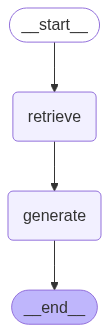

In [31]:
from IPython.display import Image, display

# 绘制Mermaid图并显示
# 注意：这需要在您的环境中安装Graphviz或类似的工具来渲染图像。
# 如果您在JupyterLab中遇到问题，可能需要安装'python-graphviz'和'graphviz'系统包。
# 例如：pip install graphviz 和 sudo apt-get install graphviz (Linux) 或 brew install graphviz (macOS)
display(Image(graph.get_graph().draw_mermaid_png()))


In [32]:
# 您是否需要使用LangGraph？对于简单的链，您不一定需要LangGraph。然而，当您的应用程序变得更复杂，需要多步骤决策、循环或更复杂的流程时，LangGraph的强大编排能力将变得非常有用。

In [33]:
# 2.6. 使用 (Usage)

# 让我们测试一下我们的应用程序！LangGraph支持多种调用模式，包括同步（sync）、异步（async）和流式（streaming）。

In [34]:
# 同步调用 (Invoke):

In [35]:
# 确保 graph 变量在此处可用
test_question = "What is Task Decomposition?"
print(f"正在同步调用应用程序，问题: '{test_question}'")
result = graph.invoke({"question": test_question})

print("\n--- 同步调用结果 ---")
print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")


正在同步调用应用程序，问题: 'What is Task Decomposition?'
执行检索节点：正在为问题 'What is Task Decomposition?' 检索文档...
检索节点完成：检索到 4 篇文档。
执行生成节点：正在生成答案...
生成节点完成：答案已生成。

--- 同步调用结果 ---
Context: [Document(id='493c7e21-f9bd-4b09-b583-f731ae043fb2', metadata={'start_index': 2578, 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on 

In [36]:
# 流式步骤 (Stream steps):流式模式允许您在每个步骤完成时获取更新，这对于长时间运行的应用程序很有用。

In [37]:
# 确保 graph 变量在此处可用
test_question = "What is Task Decomposition?"
print(f"正在流式获取应用程序步骤更新，问题: '{test_question}'")
for step in graph.stream(
    {"question": test_question}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")


正在流式获取应用程序步骤更新，问题: 'What is Task Decomposition?'
执行检索节点：正在为问题 'What is Task Decomposition?' 检索文档...
检索节点完成：检索到 4 篇文档。
{'retrieve': {'context': [Document(id='493c7e21-f9bd-4b09-b583-f731ae043fb2', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, 

In [38]:
# 流式令牌 (Stream tokens):流式令牌模式允许您在LLM生成答案时逐个获取令牌（token），这对于实时用户体验非常有用。

In [39]:
# 确保 graph 变量在此处可用
test_question = "What is Task Decomposition?"
print(f"正在流式获取LLM生成的令牌，问题: '{test_question}'")
for message, metadata in graph.stream(
    {"question": test_question}, stream_mode="messages"
):
    # message.content 包含生成的文本，end='|' 只是为了在每个令牌后添加分隔符
    print(message.content, end="|")
print("\n") # 打印一个换行符，以便下一个输出不会紧跟在令牌之后


正在流式获取LLM生成的令牌，问题: 'What is Task Decomposition?'
执行检索节点：正在为问题 'What is Task Decomposition?' 检索文档...
检索节点完成：检索到 4 篇文档。
执行生成节点：正在生成答案...
Task decomposition is a process that breaks down a complex task into smaller, manageable parts or subgoals. This can be achieved through various methods, including using a Large Language Model (LLM) with simple prompts, employing task-specific instructions, or incorporating| human inputs. An alternative approach, LLM+P, involves outsourcing long-horizon planning to an external classical planner using PDDL as an interface.|生成节点完成：答案已生成。




In [40]:
# 返回来源 (Returning sources)通过将检索到的上下文存储在图的状态中，我们可以在状态的"context"字段中获取模型生成答案的来源文档。

# 深入了解：

# Chat models: 接收一系列消息并返回一个消息。

# PromptTemplate: 用于构建结构化提示的工具，可以动态插入变量。

In [41]:
# 2.7. 自定义提示 (Customizing the prompt)

# 如上所示，我们可以从提示中心加载提示。提示也可以轻松自定义。例如：

In [42]:
from langchain_core.prompts import PromptTemplate

template = """使用以下上下文片段来回答最后的问题。
如果你不知道答案，就说你不知道，不要试图编造答案。
最多使用三句话，并尽可能保持答案简洁。
在答案的末尾总是说“感谢您的提问！”。

{context}

问题: {question}

有用的答案:"""
custom_rag_prompt = PromptTemplate.from_template(template)

# 打印自定义提示的示例
print("自定义RAG提示模板内容示例:")
print(custom_rag_prompt.invoke({"context": "(一些上下文)", "question": "(一个问题)"}).text)


自定义RAG提示模板内容示例:
使用以下上下文片段来回答最后的问题。
如果你不知道答案，就说你不知道，不要试图编造答案。
最多使用三句话，并尽可能保持答案简洁。
在答案的末尾总是说“感谢您的提问！”。

(一些上下文)

问题: (一个问题)

有用的答案:


In [43]:
# 您可以根据需要修改template字符串来定制提示的行为和语气。

In [44]:
# 查询分析 (Query analysis)
# 到目前为止，我们是使用原始输入查询执行检索的。然而，让模型生成用于检索的查询有一些优点。例如：

# 除了语义搜索之外，我们还可以构建结构化过滤器（例如，“查找自2020年以来的文档”）；

# 模型可以将用户查询（可能是多方面的或包含不相关语言）重写为更有效的搜索查询。

# 查询分析利用模型从原始用户输入转换或构建优化的搜索查询。我们可以轻松地将查询分析步骤合并到我们的应用程序中。为了说明目的，让我们向向量存储中的文档添加一些元数据。我们将向文档添加一些（人为设计的）部分，以后可以根据这些部分进行过滤。

In [45]:
# 1. 添加元数据

# 首先，我们为每个文档块添加一个"section"元数据字段，将其分为“开头”、“中间”和“结尾”。

In [46]:
# 确保 all_splits 变量在此处可用
total_documents = len(all_splits)
third = total_documents // 3 # 将文档大致分为三等份

print("正在为文档添加 'section' 元数据...")
for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"
print("元数据添加完成。")

# 打印第一个文档的元数据，查看新增的 'section' 字段
print("\n第一个文档的元数据示例:")
print(all_splits[0].metadata)


正在为文档添加 'section' 元数据...
元数据添加完成。

第一个文档的元数据示例:
{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 8, 'section': 'beginning'}


In [47]:
# 2. 更新向量存储

# 接下来，我们需要更新向量存储中的文档。我们将为此使用一个简单的InMemoryVectorStore，因为它支持我们稍后将使用的特定功能（即元数据过滤）。请参考您所选向量存储的集成文档，了解其相关功能。

# 注意： 如果您之前使用了Chroma并将其持久化到磁盘，为了演示InMemoryVectorStore的过滤功能，我们在这里创建一个新的内存中向量存储。在实际应用中，您可能会选择一个支持元数据过滤的持久化向量存储。

In [48]:
from langchain_core.vectorstores import InMemoryVectorStore

print("正在创建新的 InMemoryVectorStore 并重新添加文档...")
# 创建一个新的InMemoryVectorStore实例
vector_store = InMemoryVectorStore(embeddings)
# 将带有新元数据的文档重新添加到新的向量存储中
_ = vector_store.add_documents(all_splits)
print("InMemoryVectorStore 已创建并文档已添加。")


正在创建新的 InMemoryVectorStore 并重新添加文档...
InMemoryVectorStore 已创建并文档已添加。


In [49]:
# 3. 定义搜索查询Schema

# 接下来，我们为搜索查询定义一个Schema。我们将为此目的使用结构化输出。这里我们将查询定义为包含一个字符串查询和一个文档部分（“开头”、“中间”或“结尾”），但您可以根据需要进行定义。

In [50]:
from typing import Literal
from typing_extensions import Annotated, TypedDict

# 定义一个结构化的搜索查询Schema
class Search(TypedDict):
    """搜索查询。"""
    query: Annotated[str, ..., "要运行的搜索查询。"]
    section: Annotated[
        Literal["beginning", "middle", "end"], # section字段只能是这三个值之一
        ...,
        "要查询的文档部分。",
    ]

print("搜索查询Schema (Search TypedDict) 已定义。")


搜索查询Schema (Search TypedDict) 已定义。


In [51]:
# 4. 更新LangGraph应用程序

# 最后，我们向LangGraph应用程序添加一个步骤，用于从用户的原始输入生成结构化查询。

In [52]:
# 确保 llm, prompt, vector_store, Search 和 Document 变量在此处可用
from langgraph.graph import START, StateGraph

# 更新应用程序的状态，包含 'query' 字段
class State(TypedDict):
    question: str
    query: Search # 新增的结构化查询字段
    context: List[Document]
    answer: str

def analyze_query(state: State):
    """
    查询分析步骤：使用LLM将用户问题转换为结构化搜索查询。
    输入: state (包含 'question')
    输出: 包含 'query' (结构化搜索查询) 的字典
    """
    print(f"执行查询分析节点：正在分析问题 '{state['question']}'...")
    # 使用with_structured_output方法，让LLM按照Search TypedDict的结构生成输出
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    print(f"查询分析节点完成：生成的结构化查询为 {query}")
    return {"query": query}

def retrieve(state: State):
    """
    检索步骤：根据结构化查询（包含查询字符串和section过滤器）从向量存储中检索相关文档。
    输入: state (包含 'query')
    输出: 包含 'context' (检索到的文档列表) 的字典
    """
    query = state["query"]
    print(f"执行检索节点：正在使用查询 '{query['query']}' 和 section '{query['section']}' 检索文档...")
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        # 使用lambda函数作为过滤器，只检索metadata中section与query['section']匹配的文档
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    print(f"检索节点完成：检索到 {len(retrieved_docs)} 篇文档。")
    return {"context": retrieved_docs}

def generate(state: State):
    """
    生成步骤：使用检索到的文档和原始问题生成答案。
    输入: state (包含 'question' 和 'context')
    输出: 包含 'answer' (LLM生成的答案) 的字典
    """
    print("执行生成节点：正在生成答案...")
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    print("生成节点完成：答案已生成。")
    return {"answer": response.content}

# 重新构建和编译图，包含新的 analyze_query 步骤
print("正在重新编译LangGraph应用程序，包含查询分析步骤...")
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query") # 起始点现在连接到 analyze_query
graph = graph_builder.compile()
print("LangGraph应用程序重新编译完成。")


正在重新编译LangGraph应用程序，包含查询分析步骤...
LangGraph应用程序重新编译完成。


In [53]:
# 重新绘制的LangGraph流程图：

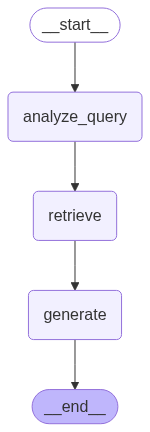

In [54]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [55]:
# 测试查询分析功能：

# 我们可以通过专门要求从文章末尾获取上下文来测试我们的实现。请注意，模型在答案中包含了不同的信息。

In [56]:
# 确保 graph 变量在此处可用
test_question_with_filter = "What does the end of the post say about Task Decomposition?"
print(f"正在流式获取应用程序步骤更新，问题: '{test_question_with_filter}'")
for step in graph.stream(
    {"question": test_question_with_filter},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")


正在流式获取应用程序步骤更新，问题: 'What does the end of the post say about Task Decomposition?'
执行查询分析节点：正在分析问题 'What does the end of the post say about Task Decomposition?'...
查询分析节点完成：生成的结构化查询为 {'section': 'end', 'query': 'Task Decomposition'}
{'analyze_query': {'query': {'section': 'end', 'query': 'Task Decomposition'}}}

----------------

执行检索节点：正在使用查询 'Task Decomposition' 和 section 'end' 检索文档...
检索节点完成：检索到 4 篇文档。
{'retrieve': {'context': [Document(id='25eec2d5-9ea3-49c6-bd77-12cdb04830fa', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 38621, 'section': 'end'}, page_content='are imported by that file, and so on.\\nFollow a language and framework appropriate best practice file naming convention.\\nMake sure that files contain all imports, types etc. The code should be fully functional. Make sure that code in different files are compatible with each other.\\nBefore you finish, double check that all parts of the architecture is present in the files.\\n"')

In [57]:
# 在流式步骤和LangSmith跟踪中，我们现在可以观察到被馈送到检索步骤的结构化查询。

# 查询分析是一个丰富的问题，有广泛的方法。请参阅相关的操作指南以获取更多示例。

In [58]:
# 下一步 (Next steps)
# 我们已经涵盖了构建一个基于数据的基本Q&A应用程序的步骤：

# 使用Document Loader加载数据。

# 使用Text Splitter对索引数据进行分块，使其更容易被模型使用。

# 嵌入数据并将数据存储在VectorStore中。

# 响应传入问题，检索先前存储的文本块。

# 使用检索到的文本块作为上下文生成答案。

# 增加了查询分析功能，使LLM能够生成结构化查询，从而实现更精确的检索。

# 在教程的第二部分，我们将扩展这里的实现，以适应对话式交互和多步检索过程。